In [1]:
import numpy as np
import matplotlib.pyplot as plt
import camb

from scipy.interpolate import interp1d
from classy import Class
from multiprocessing.pool import Pool

%matplotlib inline
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams.update({'axes.labelsize' : 20})
plt.rcParams.update({'axes.grid' : False})
import seaborn as sns
sns.color_palette("colorblind")
plt.style.use("MNRAS_Style")

In [10]:
class_ref = {
    #'recombination': 'RECFAST',
    #'tol_ncdm_bg':1.e-10,
    # 'recfast_Nz0':100000,
    #'tol_thermo_integration':1.e-5,
    #'recfast_x_He0_trigger_delta':0.01,
    #'recfast_x_H0_trigger_delta':0.01,
    #'evolver':0,
    #'k_min_tau0':0.002,
    #'k_max_tau0_over_l_max':3.,
    #'k_step_sub':0.015,
    #'k_step_super':0.0001,
    #'k_step_super_reduction':0.1,
    #'start_small_k_at_tau_c_over_tau_h':0.0004,
    #'start_large_k_at_tau_h_over_tau_k':0.05,
    #'tight_coupling_trigger_tau_c_over_tau_h':0.005,
    #'tight_coupling_trigger_tau_c_over_tau_k':0.008,
    #'start_sources_at_tau_c_over_tau_h':0.006,
    #'l_max_g':50,
    #'l_max_pol_g':25,
    #'l_max_ur':50,
    #'l_max_ncdm':50,
    #'tol_perturbations_integration':1.e-6,
    #'perturbations_sampling_stepsize':0.01,
    #'l_logstep':1.026,
    #'l_linstep':25,
    #'hyper_sampling_flat':12.,
    #'hyper_sampling_curved_low_nu':10.,
    #'hyper_sampling_curved_high_nu':10.,
    #'hyper_nu_sampling_step':10.,
    #'hyper_phi_min_abs':1.e-10,
    #'hyper_x_tol':1.e-4,
    #'hyper_flat_approximation_nu':1.e6,
    #'q_linstep':0.20,
    #'q_logstep_spline':20.,
    #'q_logstep_trapzd':0.5,
    #'q_numstep_transition':250,
    #'transfer_neglect_delta_k_S_t0':100.,
    #'transfer_neglect_delta_k_S_t1':100.,
    #'transfer_neglect_delta_k_S_t2':100.,
    #'transfer_neglect_delta_k_S_e':100.,
    #'transfer_neglect_delta_k_V_t1':100.,
    #'transfer_neglect_delta_k_V_t2':100.,
    #'transfer_neglect_delta_k_V_e':100.,
    #'transfer_neglect_delta_k_V_b':100.,
    #'transfer_neglect_delta_k_T_t2':100.,
    #'transfer_neglect_delta_k_T_e':100.,
    #'transfer_neglect_delta_k_T_b':100.,
    #'neglect_CMB_sources_below_visibility':1.e-30,
    #'transfer_neglect_late_source':3000.,
    #'halofit_k_per_decade':3000.,
    #'l_switch_limber':40.,
    #'accurate_lensing':0,
    #'num_mu_minus_lmax':1000.,
    #'delta_l_max':1000.,
#        'nonlinear_verbose' : 2

}

# additional precision parameters for neutrinos only
class_ref_nu = {
    #'radiation_streaming_approximation':2,
    #'radiation_streaming_trigger_tau_over_tau_k':240.,
    #'radiation_streaming_trigger_tau_c_over_tau':100.,
    #'ur_fluid_approximation':2,
    #'ur_fluid_trigger_tau_over_tau_k':50.,
    #'ncdm_fluid_approximation':3,
    #'ncdm_fluid_trigger_tau_over_tau_k':51.,
    #'tol_ncdm_synchronous':1.e-10,
    #'tol_ncdm_newtonian':1.e-10,
}

In [11]:
# Parameter ranges
Omega_c_min, Omega_c_max = 0.2, 0.4
Omega_b_min, Omega_b_max = 0.035, 0.065
Omega_k_min, Omega_k_max = -0.05, 0.05
h_min, h_max = 0.5, 0.9
ns_min, ns_max = 0.9, 1.0
logAs_min, logAs_max = np.log10(5E-10), np.log10(5E-9)
w0_min, w0_max = -1.3, -0.7
wa_min, wa_max = -1.73, 1.28
m_nu_min, m_nu_max = 0., 1.0
zs = [0.0]#1.008916e+00]
zs = np.array(zs)
nuFlag=False
k = np.logspace(-3,np.log10(20),2000)

In [12]:
def run_camb(cosmo_dict,k,z,nu=False, darkmatter=True, mead='mead2020'):
    camb.camb.set_feedback_level(level=0)
    cosmo_dict['Omcdm'] = cosmo_dict['Omcb']-cosmo_dict['Omb']
    nonlinear = camb.nonlinear.Halofit()
    if darkmatter:
        nonlinear.set_params(halofit_version=mead)#, HMCode_logT_AGN=-20,)
    else:
        nonlinear.set_params(halofit_version=mead+'_feedback',HMCode_logT_AGN=cosmo_dict['TAGN'])#, HMCode_logT_AGN=-20,)
    pars = camb.CAMBparams(NonLinearModel =nonlinear)
    pars.set_cosmology(H0=cosmo_dict['h']*100,
                       ombh2=cosmo_dict['Omb']*cosmo_dict['h']**2,
                       omch2=cosmo_dict['Omcdm']*cosmo_dict['h']**2,
                       mnu=cosmo_dict['smnu'] if nuFlag else 0., 
                       num_massive_neutrinos=1 if nuFlag else 0,
                       YHe=cosmo_dict['Y_p'],
                       omk=0, tau=0.06) #fixed parameters, Planck neutrinos
    #pars.set_accuracy(AccuracyBoost=3.0, lAccuracyBoost=3.0, DoLateRadTruncation=False)
    pars.InitPower.set_params(ns=cosmo_dict['ns'],
                              As=cosmo_dict['As'])

    pars.set_matter_power(redshifts=zs,kmax=50/cosmo_dict['h'])#, kmax=kmax/h) 
    pars.share_delta_neff = True 

    results = camb.get_results(pars)
    camb_interp = camb.get_matter_power_interpolator(pars,nonlinear=False,kmax=50/cosmo_dict['h'])
    pinterp = camb_interp.P #defaults #takes (z,k) pairs
    camb_interp = camb.get_matter_power_interpolator(pars,nonlinear=True,kmax=50/cosmo_dict['h'])
    pinterp_nonlinear = camb_interp.P #defaults #takes (z,k) pairs

    return pinterp(z,k), pinterp_nonlinear(z,k), results


In [13]:
#should really just make a private toolbox with these functions somewhere...
import copy
def run_class(cosmo_dict_in,k,z,nu=False,pk=False,gauge='synchronous',darkmatter=True, mead="HMcode2020"):
    cosmo_dict=copy.deepcopy(cosmo_dict_in)
    '''Simple call to boltzmann code using input cosmology parameter vector. k in h/Mpc.'''
    #setup
    if('h' not in cosmo_dict.keys()):
        h = cosmo_dict['H0']/100.
    elif('H0' not in cosmo_dict.keys()):
        cosmo_dict['H0'] = cosmo_dict['h']*100.
        h = cosmo_dict['h']
    if('Omcdm' not in cosmo_dict.keys()):
        cosmo_dict['Omcdm'] = cosmo_dict['Omcb']-cosmo_dict['Omb']
        # cosmo_dict['Omcdm'] = cosmo_dict['Omm']-cosmo_dict['Omb']
    c,G = 2.99792e5,4.30071e-9 
    cosmo_dict['non linear']=mead
    if darkmatter:
        None
    else:
        cosmo_dict['hmcode2020log10tagn']=cosmo_dict['TAGN']


    h=cosmo_dict['h']
    if(nu): 
        #use Planck single massive neutrino if using neutrinos
        N_ncdm=1
        m_ncdm=cosmo_dict['smnu']
    else:
        N_ncdm=0
        m_ncdm=0 
    
    N_ur=3.046-N_ncdm
    # N_ur = 3.046
    #print("Nur: {0:.3f}, Nncdm: {1:.3f}, mncdm: {2:.3f}".format(N_ur,N_ncdm,m_ncdm))
    
    ceng = Class()
    #gross but don't want to look up how to do it right now
    if(nuFlag): 
        ceng.set({'h':h,
              'omega_b':cosmo_dict['Omb']*h**2,
              'omega_cdm':cosmo_dict['Omcdm']*h**2,
              #'omega_r':cosmo_dict['Omr']*h**2,
              'n_s':cosmo_dict['ns'],
              'A_s':cosmo_dict['As'],
              'gauge':gauge,
              'N_ur': N_ur,
              'N_ncdm': N_ncdm,
              'T_ncdm': 0.7133,  # IMPORTANT, see page 11 of arxiv:1104.2935
              'm_ncdm': m_ncdm,
              'YHe': cosmo_dict['Y_p'],
              'ncdm_fluid_approximation':3,
              'z_reio': 7.6711,
            'non linear':cosmo_dict['non linear'],
                  'z_max_pk':1.1,
                  'Omega_k' : 0.
              })
        if not darkmatter:
            ceng.set({'hmcode2020log10tagn':cosmo_dict['hmcode2020log10tagn']})
    else: 
        ceng.set({'h':h,
              'omega_b':cosmo_dict['Omb']*h**2,
              'omega_cdm':cosmo_dict['Omcdm']*h**2,
              #'omega_r':cosmo_dict['Omr']*h**2,
              'n_s':cosmo_dict['ns'],
              'A_s':cosmo_dict['As'],
              'gauge':gauge,
              'N_ur': N_ur,
#               'N_ncdm': N_ncdm,
#               'm_ncdm': m_ncdm,
              'YHe': cosmo_dict['Y_p'],
              'ncdm_fluid_approximation':3,
              'z_reio': 7.6711,    
                'non linear':cosmo_dict['non linear'],
                'z_max_pk':1.1,
                'Omega_k' : 0.
              })
        if not darkmatter:
            ceng.set({'hmcode2020log10tagn':cosmo_dict['hmcode2020log10tagn']})
    #print(m_ncdm)
    #print(ceng.pars)
    #need lower z_max ow issues long complaint, need z<z_rec for pk to work apparently
    ceng.set(class_ref)
    ceng.set(class_ref_nu)
    ceng.set({'output':  'mPk','P_k_max_1/Mpc':20.0})
    ceng.compute()
    plin=[]
    for ki in k: plin.append(ceng.pk_lin(ki*h,z)*h**3) 
    pnl=[]
    for ki in k: pnl.append(ceng.pk(ki*h,z)*h**3) 
    # get P(k) at redshift z=0
    #transfers = ceng.get_transfer(z)
    #ceng.struct_cleanup()
    #ceng.empty()
        
    return _,plin,pnl,ceng

In [14]:
## Seed random number generator
#rng = np.random.default_rng(seed=42)
#ncos =2
#TAGN=7.8
## Loop over cosmologies
#max_errors = []
#allresult={}
#for z in zs:
#    print("z:", z)
#    linearratio=[]
#    HM2020DM=[]
#    HM2020TAGN=[]
#    HM2016=[]
#    cosmoall = []
#    for icos in range(ncos):
#        print("icos:", icos)
#        
#        # Cosmology
#        Omega_c = rng.uniform(Omega_c_min, Omega_c_max)
#        Omega_b = rng.uniform(Omega_b_min, Omega_b_max)
#        #Omega_k = rng.uniform(Omega_k_min, Omega_k_max) 
#        h = rng.uniform(h_min, h_max)
#        ns = rng.uniform(ns_min, ns_max)
#        logAs = rng.uniform(logAs_min, logAs_max)
#        #w0 = rng.uniform(w0_min, w0_max) if vary_w0 else -1.
#        #while True: # Ensure that dark energy does not dominate the early universe
#        #    wa = rng.uniform(wa_min, wa_max) if vary_wa else 0.
#        #    if w0+wa < 0.: break
#        m_nu = rng.uniform(m_nu_min, m_nu_max)# if vary_m_nu else 0.
#
#        
#        bolt_names = ['h','Omb','Omcb','ns','Y_p','Neff','smnu','As', 'TAGN']
#     
#        bolt_cosmo = [h,Omega_b,Omega_c+Omega_b,ns,0.24,3.046,m_nu,10**logAs, TAGN] #this is the choice of Planck TTTEEE in class for nu
#        cosmo_dict = dict(zip(bolt_names,bolt_cosmo))
#        ts0,pL0,pNL0,ceng = run_class(cosmo_dict,k,z,nu=nuFlag,pk=True,gauge='synchronous')
#        ts0,pL0,pNL0_HMcode2016,ceng = run_class(cosmo_dict,k,z,nu=nuFlag,pk=True,gauge='synchronous', mead="HMcode")
#        ts0,pL0,pNL_hy0,ceng = run_class(cosmo_dict,k,z,nu=nuFlag,pk=True,gauge='synchronous',darkmatter=False)
#        pCAMB, pCAMB_NL, camb_results = run_camb(cosmo_dict,k,z,nu=nuFlag, darkmatter=True)
#        pCAMB,  pCAMB_NL_Hy, camb_results = run_camb(cosmo_dict,k,z,nu=nuFlag, darkmatter=False)
#        pCAMB, pCAMB_NL_hmcode2016, camb_results = run_camb(cosmo_dict,k,z,nu=nuFlag, darkmatter=True, mead="mead2016")
#        linearratio.append(pL0/pCAMB - 1)
#        HM2020DM.append(pNL0/pCAMB_NL-1)
#        HM2020TAGN.append(pNL_hy0/pCAMB_NL_Hy-1)
#        HM2016.append(pNL0_HMcode2016/pCAMB_NL_hmcode2016-1)
#        cosmoall.append(cosmo_dict)
#    allresult[z]=[linearratio, HM2020DM,HM2020TAGN,HM2016,cosmoall]

In [17]:
# Seed random number generator
rng = np.random.default_rng(seed=42)
ncos = 450
TAGN = 8.2
# Loop over cosmologies
max_errors = []
allresult={}
def get_result(cosmo_dict):
    ts0,pL0,pNL0,ceng = run_class(cosmo_dict,k,z,nu=nuFlag,pk=True,gauge='synchronous')
    if ceng.sigma8()<0.616:
        return None, None, None,None,None
    ts0,pL0,pNL0_HMcode2016,ceng = run_class(cosmo_dict,k,z,nu=nuFlag,pk=True,gauge='synchronous', mead="HMcode")
    ts0,pL0,pNL_hy0,ceng = run_class(cosmo_dict,k,z,nu=nuFlag,pk=True,gauge='synchronous',darkmatter=False)
    pCAMB, pCAMB_NL, camb_results = run_camb(cosmo_dict,k,z,nu=nuFlag, darkmatter=True)
    pCAMB,  pCAMB_NL_Hy, camb_results = run_camb(cosmo_dict,k,z,nu=nuFlag, darkmatter=False)
    pCAMB, pCAMB_NL_hmcode2016, camb_results = run_camb(cosmo_dict,k,z,nu=nuFlag, darkmatter=True, mead="mead2016")
    return [(pL0/pCAMB - 1), (pNL0/pCAMB_NL-1), (pNL_hy0/pCAMB_NL_Hy-1), (pNL0_HMcode2016/pCAMB_NL_hmcode2016-1),(cosmo_dict)]

for z in zs:
    print("z:", z)
    linearratio=[]
    HM2020DM=[]
    HM2020TAGN=[]
    HM2016=[]
    cosmoall = []
    cosmorecord = []
    for icos in range(ncos):
        print("icos:", icos)
        # Cosmology
        Omega_c = rng.uniform(Omega_c_min, Omega_c_max)
        Omega_b = rng.uniform(Omega_b_min, Omega_b_max)
        #Omega_k = rng.uniform(Omega_k_min, Omega_k_max) 
        h = rng.uniform(h_min, h_max)
        ns = rng.uniform(ns_min, ns_max)
        logAs = rng.uniform(logAs_min, logAs_max)
        #w0 = rng.uniform(w0_min, w0_max) if vary_w0 else -1.
        #while True: # Ensure that dark energy does not dominate the early universe
        #    wa = rng.uniform(wa_min, wa_max) if vary_wa else 0.
        #    if w0+wa < 0.: break
        m_nu = rng.uniform(m_nu_min, m_nu_max)# if vary_m_nu else 0.

        if (Omega_b*h**2<5.000000e-03) or (Omega_b*h**2>3.900000e-02):
            continue
        bolt_names = ['h','Omb','Omcb','ns','Y_p','Neff','smnu','As', 'TAGN']
     
        bolt_cosmo = [h,Omega_b,Omega_c+Omega_b,ns,0.24,3.046,m_nu,10**logAs, TAGN] #this is the choice of Planck TTTEEE in class for nu
        cosmo_dict = dict(zip(bolt_names,bolt_cosmo))
        cosmoall.append(cosmo_dict)
    pool = Pool(24)
    resultall = pool.map(get_result, cosmoall)
    for result in resultall:
        #if result==None:
        #    continue
        linearratio.append(result[0])
        HM2020DM.append(result[1])
        HM2020TAGN.append(result[2])
        HM2016.append(result[3])
        cosmorecord.append(result[4])

    allresult[z]=[linearratio, HM2020DM,HM2020TAGN,HM2016,cosmoall,cosmorecord]
    pool.close()

z: 0.0
icos: 0
icos: 1
icos: 2
icos: 3
icos: 4
icos: 5
icos: 6
icos: 7
icos: 8
icos: 9
icos: 10
icos: 11
icos: 12
icos: 13
icos: 14
icos: 15
icos: 16
icos: 17
icos: 18
icos: 19
icos: 20
icos: 21
icos: 22
icos: 23
icos: 24
icos: 25
icos: 26
icos: 27
icos: 28
icos: 29
icos: 30
icos: 31
icos: 32
icos: 33
icos: 34
icos: 35
icos: 36
icos: 37
icos: 38
icos: 39
icos: 40
icos: 41
icos: 42
icos: 43
icos: 44
icos: 45
icos: 46
icos: 47
icos: 48
icos: 49
icos: 50
icos: 51
icos: 52
icos: 53
icos: 54
icos: 55
icos: 56
icos: 57
icos: 58
icos: 59
icos: 60
icos: 61
icos: 62
icos: 63
icos: 64
icos: 65
icos: 66
icos: 67
icos: 68
icos: 69
icos: 70
icos: 71
icos: 72
icos: 73
icos: 74
icos: 75
icos: 76
icos: 77
icos: 78
icos: 79
icos: 80
icos: 81
icos: 82
icos: 83
icos: 84
icos: 85
icos: 86
icos: 87
icos: 88
icos: 89
icos: 90
icos: 91
icos: 92
icos: 93
icos: 94
icos: 95
icos: 96
icos: 97
icos: 98
icos: 99
icos: 100
icos: 101
icos: 102
icos: 103
icos: 104
icos: 105
icos: 106
icos: 107
icos: 108
icos: 109
ico

In [12]:
allresult.keys()

dict_keys([0.0])

In [13]:
linearratio, HM2020DM,HM2020TAGN,HM2016,_,cosmo = allresult[1]

KeyError: 1

In [18]:
cmap =  plt.get_cmap('rainbow')


IndexError: index 1 is out of bounds for axis 0 with size 1

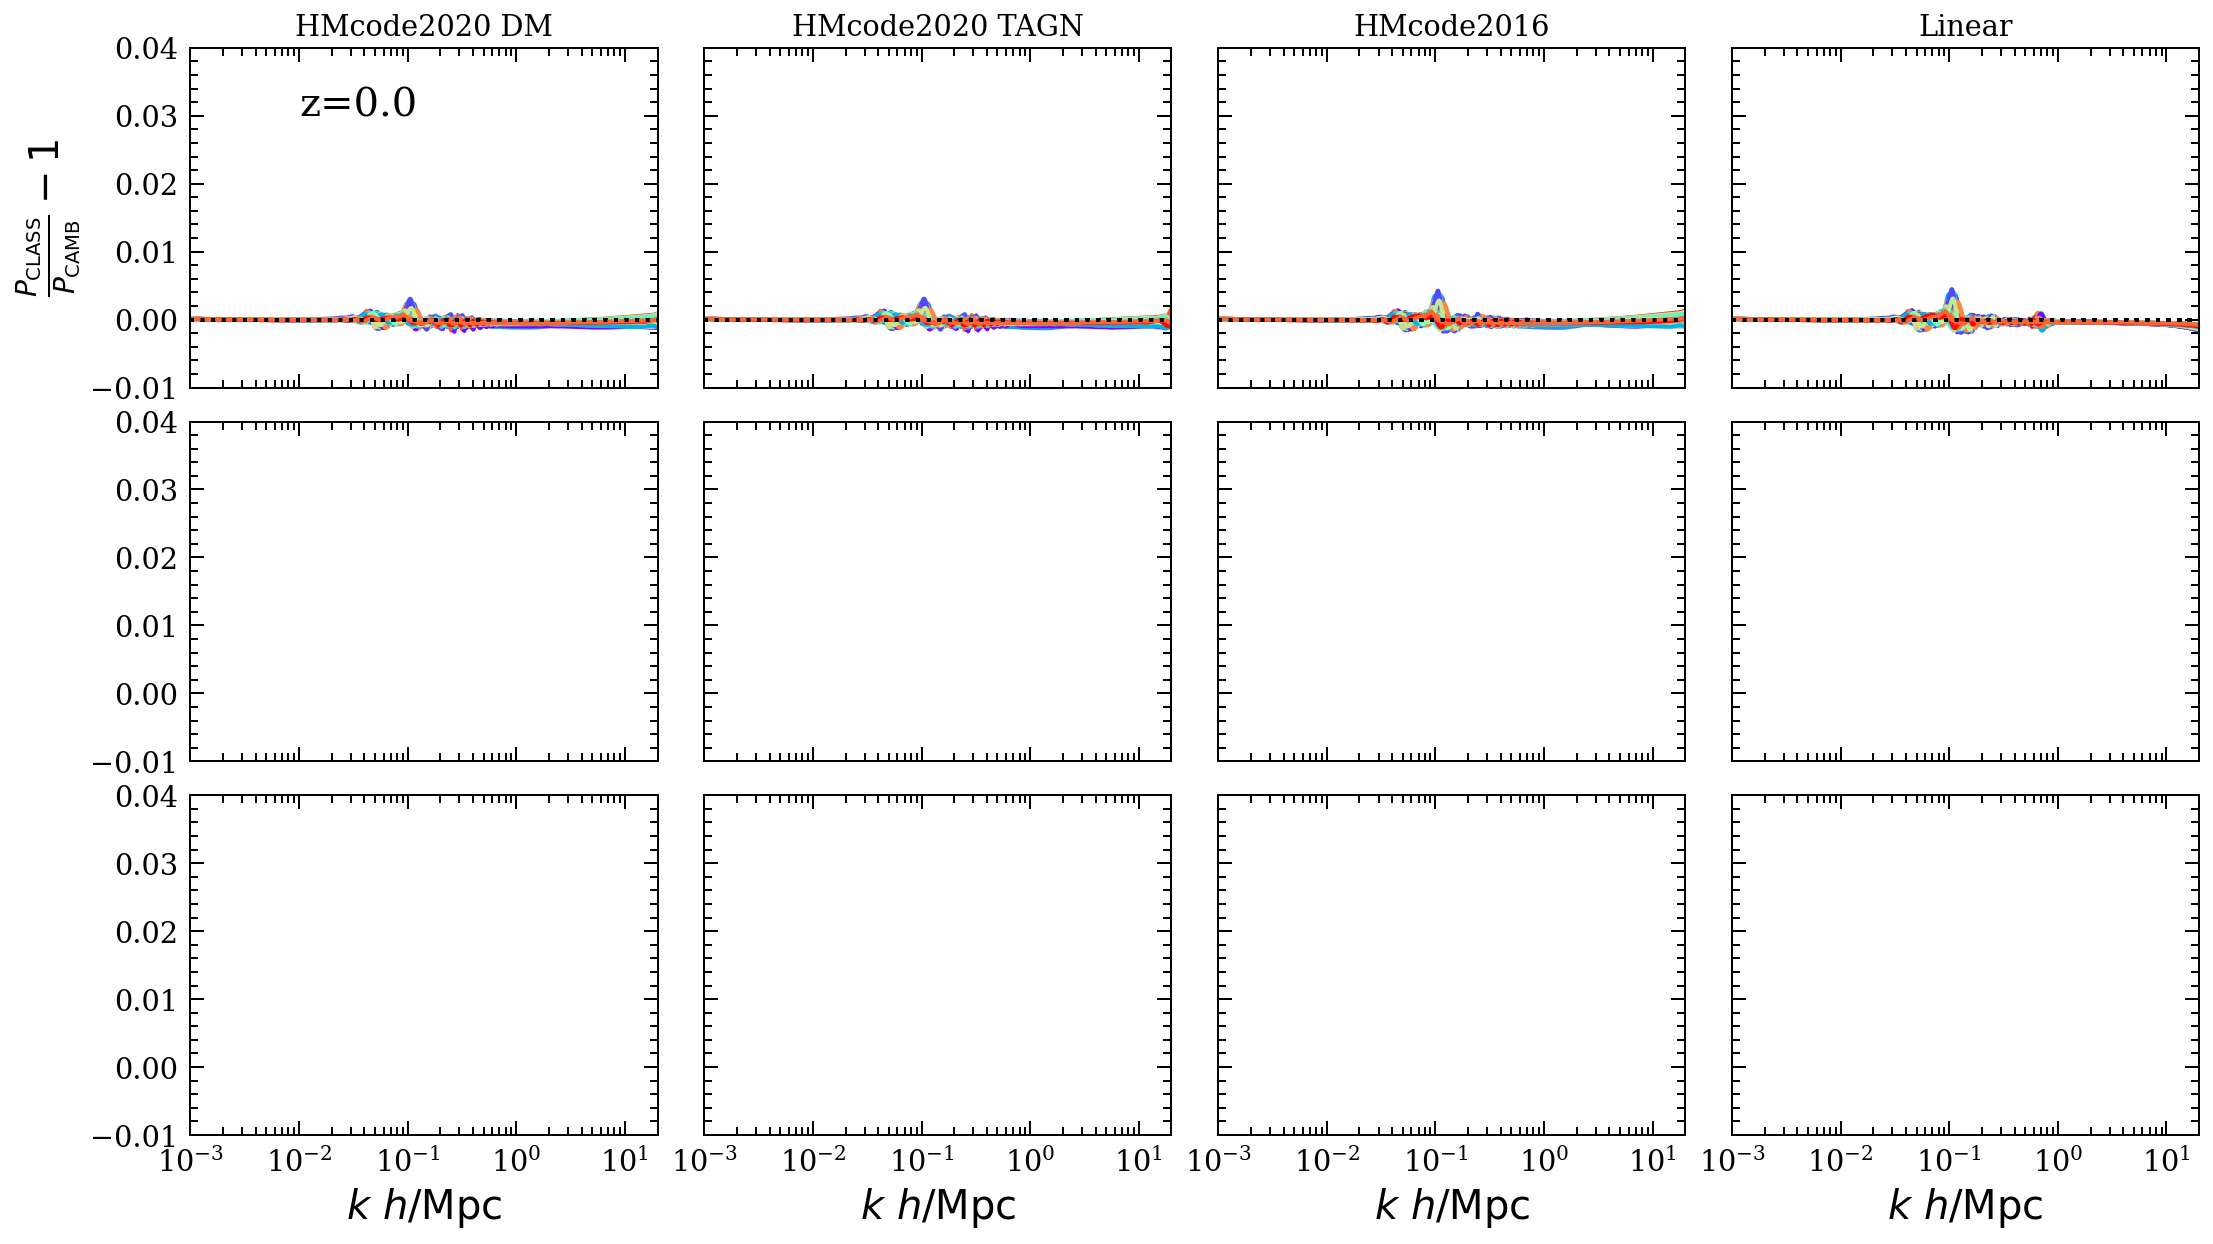

In [19]:
#newtonian vs synch gauge
fig, axes = plt.subplots(3,4,figsize=(18,10),sharey=True, sharex=True)
inum=0
for j in range(3):
    linearratio, HM2020DM,HM2020TAGN,HM2016,_,cosmo = allresult[zs[j]]
    for i in range(len(linearratio)):

        try:
            if linearratio[i]==None:
                continue
        except:
            None
        inum+=1
        l1 = linearratio[i]
        H2020 = HM2020DM[i]
        HTagn = HM2020TAGN[i]
        H2016 = HM2016[i]

        if np.max(np.abs(H2020))>0.025:
            print(np.max(np.abs(H2020)),cosmo[i])
    
        axes[j][0].plot(k,H2020, label="HMcode2020 DM", c=cmap(cosmo[i]['smnu']))
        axes[j][0].set_xscale('log')
        axes[j][0].set_ylabel(r'$\frac{P_{\rm{CLASS}}}{P_{\rm{CAMB}}} - 1$',fontsize=20)
        axes[2][0].set_xlabel(r'$k \ h/\rm{Mpc} $',fontsize=20)
        axes[j][0].axhline(0,ls=':',c='k')
        axes[0][0].set_title("HMcode2020 DM")
        axes[j][1].plot(k,HTagn, label="HMcode2020 TAGN", c=cmap(cosmo[i]['smnu']))
        axes[j][1].set_xscale('log')
        axes[2][1].set_xlabel(r'$k \ h/\rm{Mpc} $',fontsize=20)
        axes[j][1].axhline(0,ls=':',c='k')
        axes[0][1].set_title("HMcode2020 TAGN")
        axes[j][3].plot(k,l1, label="Linear", c=cmap(cosmo[i]['smnu']))
        axes[j][3].set_xscale('log')
        axes[2][3].set_xlabel(r'$k \ h/\rm{Mpc} $',fontsize=20)
        axes[j][3].axhline(0,ls=':',c='k')
        axes[0][3].set_title("Linear")
        axes[j][2].plot(k,H2016, label="HMcode2016", c=cmap(cosmo[i]['smnu']))
        axes[j][2].set_xscale('log')
        axes[2][2].set_xlabel(r'$k \ h/\rm{Mpc} $',fontsize=20)
        axes[j][2].axhline(0,ls=':',c='k')
        axes[0][2].set_title("HMcode2016")
    for i in range(4):
        axes[j][i].set_ylim(-1E-2, 4E-2)
    from matplotlib.cm import ScalarMappable
    plt.subplots_adjust(wspace=0.1,hspace=0.1)
    axes[0][0].text(1E-2,3E-2,"z={0}".format(zs[0]), size=20)
    axes[1][0].text(1E-2,3E-2,"z={0}".format(zs[1]), size=20)
    axes[2][0].text(1E-2,3E-2,"z={0}".format(zs[2]), size=20)

    sm = ScalarMappable(cmap=cmap)
    cbar_ax = fig.add_axes([0.92, 0.1, 0.02, 0.8]) # left, bottom, width, height
    fig.colorbar(sm, cax=cbar_ax).set_label(r'$m_{\nu}$(ev)', fontsize=20)


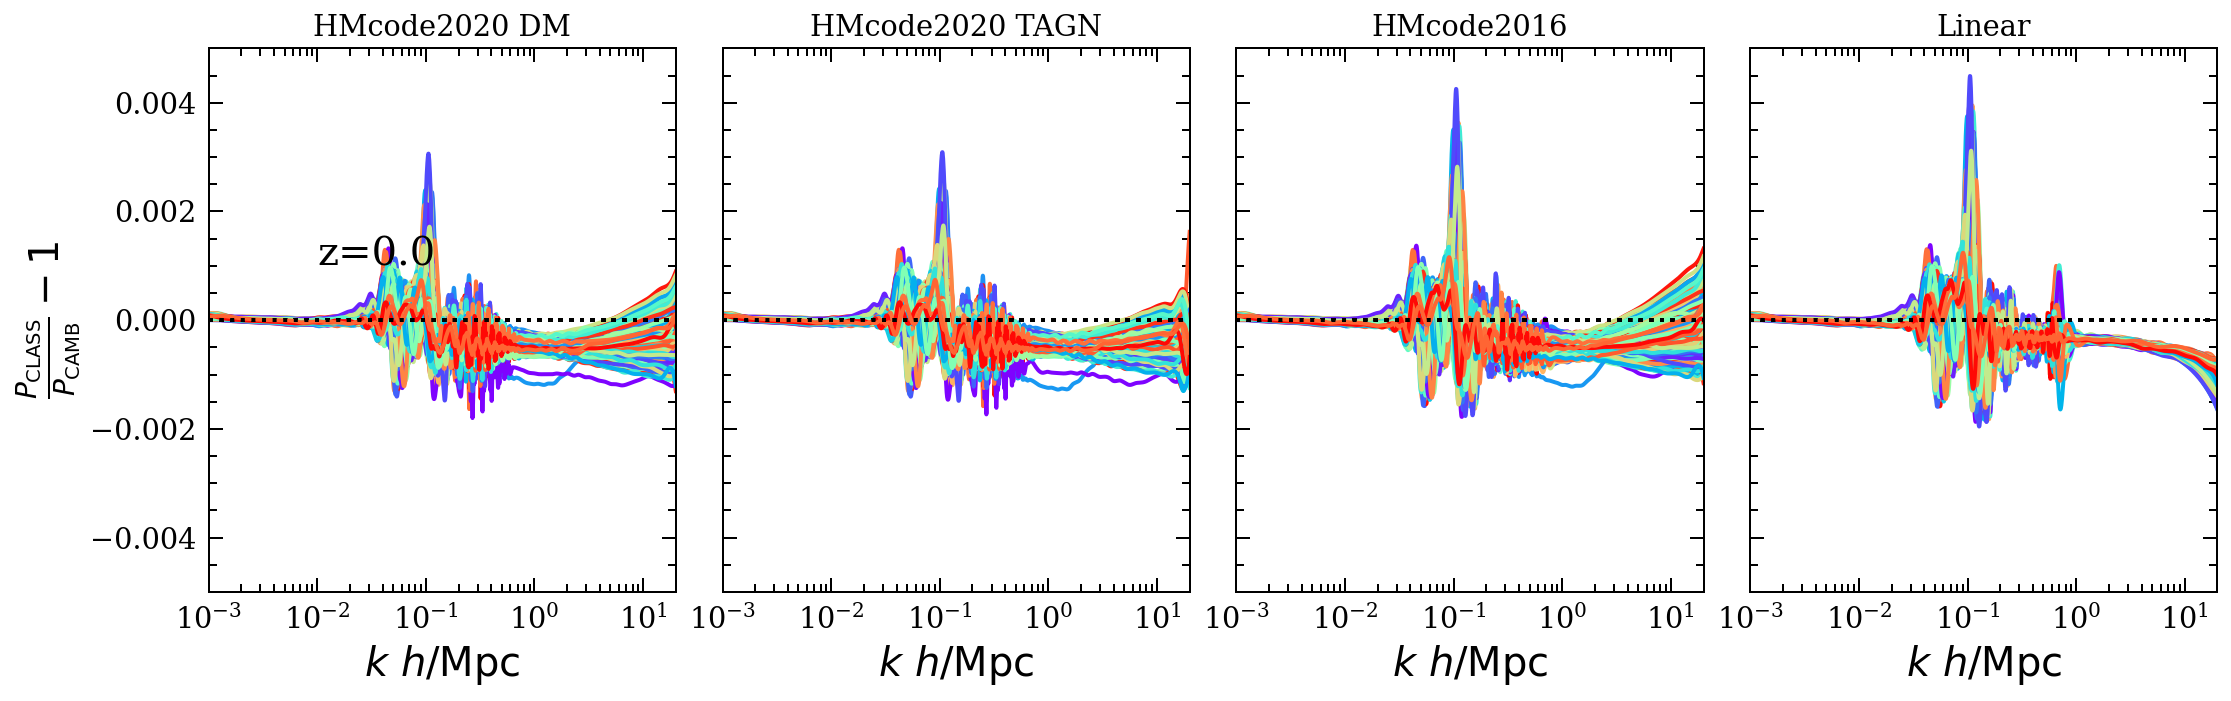

In [27]:
#newtonian vs synch gauge
fig, axes = plt.subplots(1,4,figsize=(18,5),sharey=True, sharex=True)
axes=[axes]
inum=0
for j in range(1):
    linearratio, HM2020DM,HM2020TAGN,HM2016,_,cosmo = allresult[zs[j]]
    for i in range(len(linearratio)):

        try:
            if linearratio[i]==None:
                continue
        except:
            None
        inum+=1
        l1 = linearratio[i]
        H2020 = HM2020DM[i]
        HTagn = HM2020TAGN[i]
        H2016 = HM2016[i]

        if np.max(np.abs(H2020))>0.025:
            print(np.max(np.abs(H2020)),cosmo[i])
    
        axes[j][0].plot(k,H2020, label="HMcode2020 DM", c=cmap(cosmo[i]['smnu']))
        axes[j][0].set_xscale('log')
        axes[j][0].set_ylabel(r'$\frac{P_{\rm{CLASS}}}{P_{\rm{CAMB}}} - 1$',fontsize=20)
        axes[0][0].set_xlabel(r'$k \ h/\rm{Mpc} $',fontsize=20)
        axes[j][0].axhline(0,ls=':',c='k')
        axes[0][0].set_title("HMcode2020 DM")
        axes[j][1].plot(k,HTagn, label="HMcode2020 TAGN", c=cmap(cosmo[i]['smnu']))
        axes[j][1].set_xscale('log')
        axes[0][1].set_xlabel(r'$k \ h/\rm{Mpc} $',fontsize=20)
        axes[j][1].axhline(0,ls=':',c='k')
        axes[0][1].set_title("HMcode2020 TAGN")
        axes[j][3].plot(k,l1, label="Linear", c=cmap(cosmo[i]['smnu']))
        axes[j][3].set_xscale('log')
        axes[0][3].set_xlabel(r'$k \ h/\rm{Mpc} $',fontsize=20)
        axes[j][3].axhline(0,ls=':',c='k')
        axes[0][3].set_title("Linear")
        axes[j][2].plot(k,H2016, label="HMcode2016", c=cmap(cosmo[i]['smnu']))
        axes[j][2].set_xscale('log')
        axes[0][2].set_xlabel(r'$k \ h/\rm{Mpc} $',fontsize=20)
        axes[j][2].axhline(0,ls=':',c='k')
        axes[0][2].set_title("HMcode2016")
    for i in range(4):
        axes[j][i].set_ylim(-5E-3,5E-3)
    from matplotlib.cm import ScalarMappable
    plt.subplots_adjust(wspace=0.1,hspace=0.1)
    axes[0][0].text(1E-2,1E-3,"z={0}".format(zs[0]), size=20)
    #axes[1][0].text(1E-2,3E-2,"z={0}".format(zs[1]), size=20)
    #axes[2][0].text(1E-2,3E-2,"z={0}".format(zs[2]), size=20)

    #sm = ScalarMappable(cmap=cmap)
    #cbar_ax = fig.add_axes([0.92, 0.1, 0.02, 0.8]) # left, bottom, width, height
    #fig.colorbar(sm, cax=cbar_ax).set_label(r'$m_{\nu}$(ev)', fontsize=20)


In [ ]:
print(inum)

In [ ]:
ts0,pL0,pNL0,ceng = run_class(cosmo_dict,k,z,nu=nuFlag,pk=True,gauge='synchronous')
#    if ceng.sigma8()<0.616:

In [ ]:
ceng.sigma8()

In [ ]:
## newtonian vs synch gauge
plt.plot(k,np.array(pNL_hy0)/np.array(pNL0) - 1, label="NL Hy")
plt.xscale('log')
plt.ylabel(r'$\frac{P_{\rm{CLASS}}}{P_{\rm{CAMB}}} - 1$',fontsize=20)
plt.xlabel(r'$k \ h/\rm{Mpc} $',fontsize=20)
plt.axhline(0,ls=':',c='k')
plt.legend()

In [14]:
## newtonian vs synch gauge
plt.plot(k,np.array(pCAMB_NL_Hy)/np.array(pCAMB_NL) - 1, label="NL Hy")
plt.xscale('log')
plt.ylabel(r'$\frac{P_{\rm{CLASS}}}{P_{\rm{CAMB}}} - 1$',fontsize=20)
plt.xlabel(r'$k \ h/\rm{Mpc} $',fontsize=20)
plt.axhline(0,ls=':',c='k')
plt.legend()

NameError: name 'pCAMB_NL_Hy' is not defined

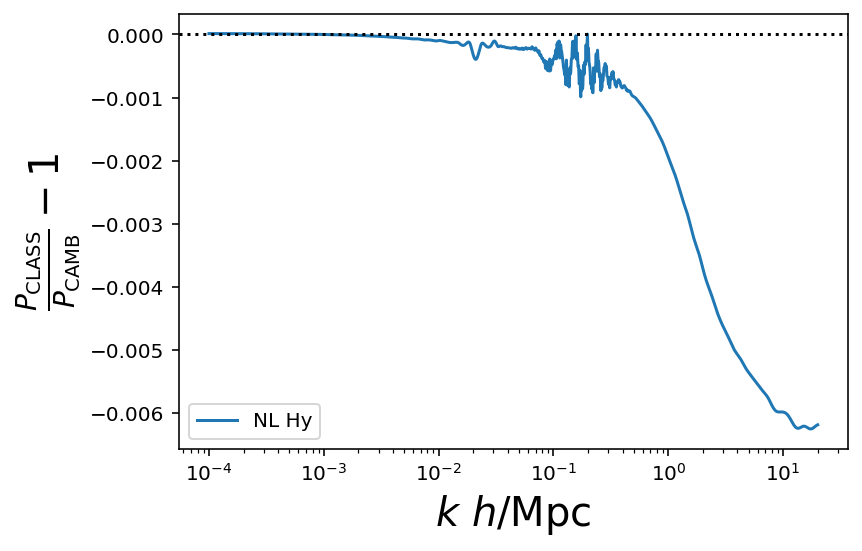

In [15]:
## newtonian vs synch gauge
plt.plot(k,pNL_hy0/pCAMB_NL_Hy - 1, label="NL Hy")
plt.xscale('log')
plt.ylabel(r'$\frac{P_{\rm{CLASS}}}{P_{\rm{CAMB}}} - 1$',fontsize=20)
plt.xlabel(r'$k \ h/\rm{Mpc} $',fontsize=20)
plt.axhline(0,ls=':',c='k')
plt.legend()

In [28]:
cosmo_dict = {'h': 0.5472023608482062, 'Omb': 0.037629497579483036, 'Omcb': 0.30999201969016116, 'ns': 0.9961897664549515, 'Y_p': 0.24, 'Neff': 3.046, 'smnu': 0.6997071338107496, 'As': 4.050892283013098e-09, 'TAGN': 8.2, 'Omcdm': 0.27236252211067813}
import pyccl as ccl

cosmo = ccl.Cosmology(
        Omega_c=cosmo_dict['Omcb']-cosmo_dict['Omb'],
        Omega_b=cosmo_dict['Omb'],
        h=cosmo_dict['h'],
        A_s=cosmo_dict['As'],
        n_s=cosmo_dict['ns'],
        Neff=cosmo_dict['Neff'],
        Omega_k=0,
        w0=-1,
        wa=0,
        #m_nu=cosmo_dict['smnu'],
        transfer_function='boltzmann_class')
pk_lin_class = ccl.linear_matter_power(cosmo, k, 1)

In [33]:
import pyccl as ccl

cosmo = ccl.Cosmology(
        Omega_c=cosmo_dict['Omcb']-cosmo_dict['Omb'],
        Omega_b=cosmo_dict['Omb'],
        h=cosmo_dict['h'],
        A_s=cosmo_dict['As'],
        n_s=cosmo_dict['ns'],
        Neff=cosmo_dict['Neff'],
        Omega_k=0,
        w0=-1,
        wa=0,
        #m_nu=cosmo_dict['smnu'],
        transfer_function='boltzmann_camb')
pk_lin_camb = ccl.linear_matter_power(cosmo, k, 1)


Text(0.5, 0, 'k(Mpc/h)')

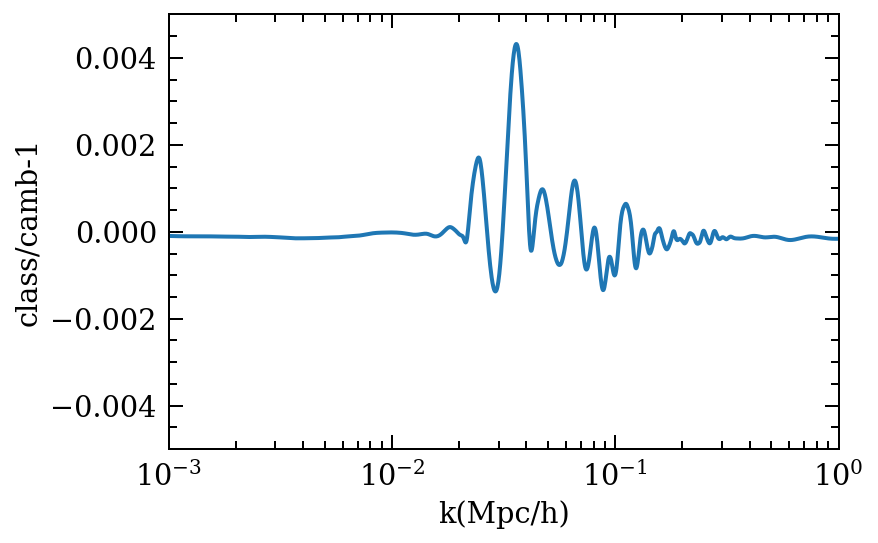

In [36]:
plt.semilogx(k, pk_lin_class/pk_lin_camb-1)
plt.xlim(1E-3, 1E0)
plt.ylim(-5E-3,5E-3)
plt.ylabel("class/camb-1")
plt.xlabel("k(Mpc/h)")

In [ ]:
class_ref = {
    'recombination': 'RECFAST',
    'tol_ncdm_bg':1.e-10,
     'recfast_Nz0':100000,
    'tol_thermo_integration':1.e-5,
    'recfast_x_He0_trigger_delta':0.01,
    'recfast_x_H0_trigger_delta':0.01,
    'evolver':0,
    'k_min_tau0':0.002,
    'k_max_tau0_over_l_max':3.,
    'k_step_sub':0.015,
    'k_step_super':0.0001,
    'k_step_super_reduction':0.1,
    'start_small_k_at_tau_c_over_tau_h':0.0004,
    'start_large_k_at_tau_h_over_tau_k':0.05,
    'tight_coupling_trigger_tau_c_over_tau_h':0.005,
    'tight_coupling_trigger_tau_c_over_tau_k':0.008,
    'start_sources_at_tau_c_over_tau_h':0.006,
    'l_max_g':50,
    'l_max_pol_g':25,
    'l_max_ur':50,
    'l_max_ncdm':50,
    #'tol_perturbations_integration':1.e-6,
    #'perturbations_sampling_stepsize':0.01,
    'l_logstep':1.026,
    'l_linstep':25,
    'hyper_sampling_flat':12.,
    'hyper_sampling_curved_low_nu':10.,
    'hyper_sampling_curved_high_nu':10.,
    'hyper_nu_sampling_step':10.,
    'hyper_phi_min_abs':1.e-10,
    'hyper_x_tol':1.e-4,
    'hyper_flat_approximation_nu':1.e6,
    'q_linstep':0.20,
    'q_logstep_spline':20.,
    'q_logstep_trapzd':0.5,
    'q_numstep_transition':250,
    'transfer_neglect_delta_k_S_t0':100.,
    'transfer_neglect_delta_k_S_t1':100.,
    'transfer_neglect_delta_k_S_t2':100.,
    'transfer_neglect_delta_k_S_e':100.,
    'transfer_neglect_delta_k_V_t1':100.,
    'transfer_neglect_delta_k_V_t2':100.,
    'transfer_neglect_delta_k_V_e':100.,
    'transfer_neglect_delta_k_V_b':100.,
    'transfer_neglect_delta_k_T_t2':100.,
    'transfer_neglect_delta_k_T_e':100.,
    'transfer_neglect_delta_k_T_b':100.,
    'neglect_CMB_sources_below_visibility':1.e-30,
    'transfer_neglect_late_source':3000.,
    'halofit_k_per_decade':3000.,
    'l_switch_limber':40.,
    'accurate_lensing':0,
    'num_mu_minus_lmax':1000.,
    'delta_l_max':1000.,
#        'nonlinear_verbose' : 2

}

# additional precision parameters for neutrinos only
class_ref_nu = {
    'radiation_streaming_approximation':2,
    'radiation_streaming_trigger_tau_over_tau_k':240.,
    'radiation_streaming_trigger_tau_c_over_tau':100.,
    'ur_fluid_approximation':2,
    'ur_fluid_trigger_tau_over_tau_k':50.,
    'ncdm_fluid_approximation':3,
    'ncdm_fluid_trigger_tau_over_tau_k':51.,
    #'tol_ncdm_synchronous':1.e-10,
    #'tol_ncdm_newtonian':1.e-10,
}

In [34]:
#should really just make a private toolbox with these functions somewhere...
import copy
def run_class(cosmo_dict_in,k,z,nu=False,pk=False,gauge='synchronous',darkmatter=True, mead="HMcode2020"):
    cosmo_dict=copy.deepcopy(cosmo_dict_in)
    '''Simple call to boltzmann code using input cosmology parameter vector. k in h/Mpc.'''
    #setup
    if('h' not in cosmo_dict.keys()):
        h = cosmo_dict['H0']/100.
    elif('H0' not in cosmo_dict.keys()):
        cosmo_dict['H0'] = cosmo_dict['h']*100.
        h = cosmo_dict['h']
    if('Omcdm' not in cosmo_dict.keys()):
        cosmo_dict['Omcdm'] = cosmo_dict['Omcb']-cosmo_dict['Omb']
        # cosmo_dict['Omcdm'] = cosmo_dict['Omm']-cosmo_dict['Omb']
    c,G = 2.99792e5,4.30071e-9 
    cosmo_dict['non linear']=mead
    if darkmatter:
        None
    else:
        cosmo_dict['hmcode2020log10tagn']=cosmo_dict['TAGN']


    h=cosmo_dict['h']
    if(nu): 
        #use Planck single massive neutrino if using neutrinos
        N_ncdm=1
        m_ncdm=cosmo_dict['smnu']
    else:
        N_ncdm=0
        m_ncdm=0 
    
    N_ur=3.046-N_ncdm
    # N_ur = 3.046
    #print("Nur: {0:.3f}, Nncdm: {1:.3f}, mncdm: {2:.3f}".format(N_ur,N_ncdm,m_ncdm))
    
    ceng = Class()
    #gross but don't want to look up how to do it right now
    if(nuFlag): 
        ceng.set({'h':h,
              'omega_b':cosmo_dict['Omb']*h**2,
              'omega_cdm':cosmo_dict['Omcdm']*h**2,
              #'omega_r':cosmo_dict['Omr']*h**2,
              'n_s':cosmo_dict['ns'],
              'A_s':cosmo_dict['As'],
              'gauge':gauge,
              'N_ur': N_ur,
              'N_ncdm': N_ncdm,
              'T_ncdm': 0.7133,  # IMPORTANT, see page 11 of arxiv:1104.2935
              'm_ncdm': m_ncdm,
              'YHe': cosmo_dict['Y_p'],
              #'ncdm_fluid_approximation':3,
              #'z_reio': 7.6711,
            'non linear':cosmo_dict['non linear'],
                  'z_max_pk':1.1,
                  'Omega_k' : 0.
              })
        if not darkmatter:
            ceng.set({'hmcode2020log10tagn':cosmo_dict['hmcode2020log10tagn']})

        if not darkmatter:
            ceng.set({'hmcode2020log10tagn':cosmo_dict['hmcode2020log10tagn']})
    #print(m_ncdm)
    #print(ceng.pars)
    #need lower z_max ow issues long complaint, need z<z_rec for pk to work apparently
    ceng.set(class_ref)
    ceng.set(class_ref_nu)
    ceng.set({'output':  'mPk','P_k_max_1/Mpc':20.0})
    ceng.compute()
    plin=[]
    for ki in k: plin.append(ceng.pk_lin(ki*h,z)*h**3) 
    pnl=[]
    for ki in k: pnl.append(ceng.pk(ki*h,z)*h**3) 
    # get P(k) at redshift z=0
    #transfers = ceng.get_transfer(z)
    #ceng.struct_cleanup()
    #ceng.empty()
        
    return _,plin,pnl,ceng

In [35]:
ts0,pL0,pNL0,ceng = run_class(cosmo_dict,k,0,nu=nuFlag,pk=True,gauge='synchronous')
pCAMB, pCAMB_NL, camb_results = run_camb(cosmo_dict,k,0,nu=nuFlag, darkmatter=True)

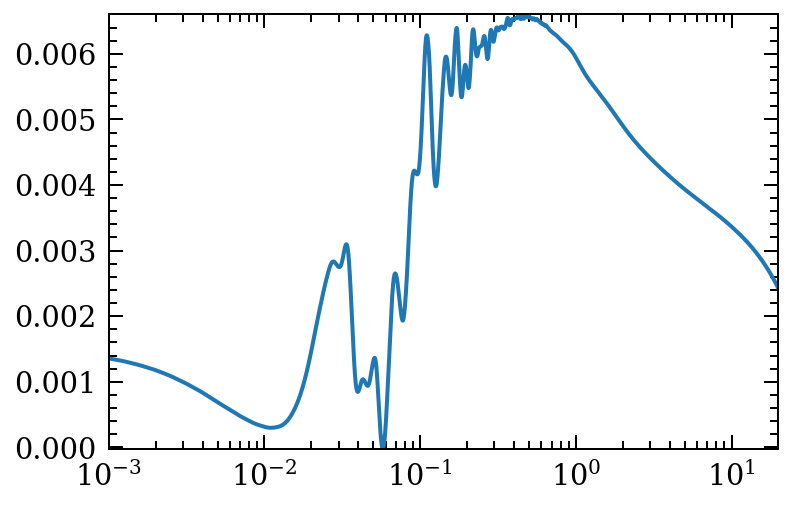

In [36]:
plt.semilogx(k, pL0/pCAMB-1)

<ipython-input-39-f38f53b2a70f>:2: RuntimeWarning: invalid value encountered in divide
  y = np.sin(x)/x


(-0.1, 0.1)

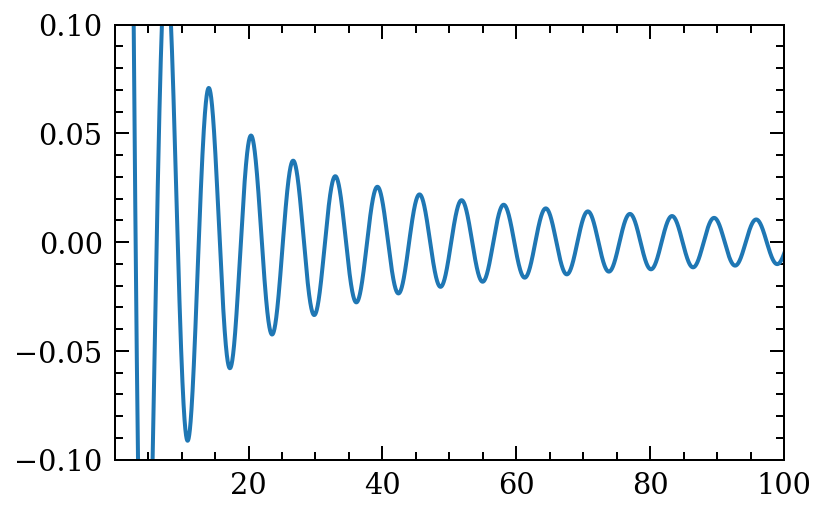

In [39]:
x =np.linspace(0,100,10000)
y = np.sin(x)/x
plt.plot(x,y)
plt.ylim(-0.1,0.1)